In [21]:
import numpy as np
from numpy import *
import array
import math
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [22]:
# CONSTANTS
# number of arms
ARMS = 10

Initialize the expected reward for each arm.

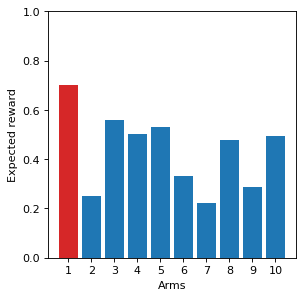

best arm 1


In [23]:
# expected reward for each of the arms (random)
exp_r = np.random.uniform(0, 1, ARMS) # E[x]
best_arm = np.argmax(exp_r) 

plt.figure(figsize=(4, 4), dpi=80)

y_pos = np.arange(len(exp_r)) + 1
plt.bar(y_pos, exp_r, align='center', color=[ "tab:red" if i==best_arm else "tab:blue" for i in range(len(exp_r)) ])
plt.xticks(y_pos)
plt.ylabel('Expected reward')
plt.xlabel('Arms')
plt.ylim(0.,1.)
plt.show()

print("best arm", best_arm + 1)


In [53]:
def avg_reward(exp_r, n, HALF_SIZE):
    '''
    Compute the average reward playing each arm A for n rounds
    exp_r: list of expected reward for each arm
    T: number of rounds
    HALF_SIZE: max reward variation
    '''
    
    avg_r = np.zeros(exp_r.shape) 
    
    for r in range(n):
        avg_r += np.random.uniform(exp_r - HALF_SIZE, exp_r + HALF_SIZE)
        
    return avg_r/n

# Experiment 1

Play the same arm 100 and 10,000 times. What do you expect to obtain?

For the LLN's law we know that the regret approaches 

- 0 for the best arm and 
- $T \Delta_a$, the gap $\Delta_a$ between the best arm and the selected arm $a$ times the number of rounds $T$ otherwise

10000 rounds
best arm 1


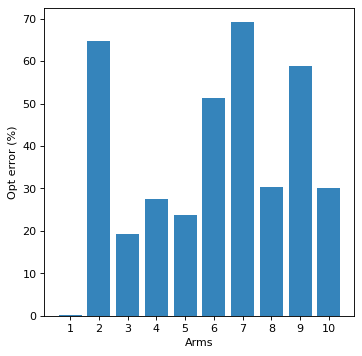

In [54]:
# experiment 1: What happens if you play the same arm
ROUNDS = 10000
HALF_SIZE = 1.
prc = np.zeros(ARMS)

avg_r = avg_reward(exp_r, ROUNDS, HALF_SIZE)
print (ROUNDS, "rounds")
print ("best arm", best_arm + 1)

# optimisation error (percentage)
for a in range (0, ARMS):
    prc[a] = (1 - avg_r[a] / exp_r[best_arm]) * 100
    
plt.figure(figsize=(5, 5), dpi=80)
y_pos = np.arange(len(prc)) + 1
plt.bar(y_pos, prc, align='center', alpha=0.9)
plt.xticks(y_pos)
plt.ylabel('Opt error (%)')
plt.xlabel('Arms')

plt.show()

I expect that the optimization error is found with more confidence, for a larger number T. With 100 rounds the optimization error is more uncertain than if we play 10,000 times. We have more accurate estimates on the optimal actions to play. Hoeffdings inequality shows us that a small gap $\Delta_a$ implies that we need a large T to have accurate estimates of the optimal actions to play. 

# Experiment 2: Explore and commit

Play each arm EXP_ROUNDS (number of rounds dedicated to exploration for each arm) and then play the arm with the highest average reward for the remaining rounds (ROUNDS - EXP_ROUNDS * ARMS). Check what happens for different values of EXP_ROUNDS

In [117]:
def compute_gap(optimal_r, emp_best_r, n):
    '''
    Compute gap between the best arm and the selected arm for n rounds
    optimal_r: optimal reward 
    emp_best_r: best empirical reward 
    n: number of rounds played
    '''
    delta = optimal_r * n - emp_best_r
    return delta
    
def optimization_error(exp_r, EXP_ROUNDS, ROUNDS, HALF_SIZE):
    '''
    Explore-Then-Commit strategy
    EXPLORE playing all the arms and finding the best empirical reward
    THEN play that arm leading to the best empirical reward
    
    Parameters.
    exp_r: expected reward
    EXP_ROUNDS: rounds to explore
    ROUNDS: rounds to play
    HALF_SIZE: max reward variation
    '''
    
    # first, explore for EXP_ROUNDS
    avg_r = avg_reward(exp_r, EXP_ROUNDS, HALF_SIZE)
    
    # best arm empirically found 
    arm = np.argmax(avg_r) 
    
    # then commit, play the best arm found for ROUNDS time
    cumul_r = 0.
    
    for r in range(0,ROUNDS):
        cumul_r += np.random.uniform(exp_r[arm] - HALF_SIZE, exp_r[arm] + HALF_SIZE)
        
    # compute optimization error
    opt = exp_r[best_arm] * ROUNDS - cumul_r
    
    return opt

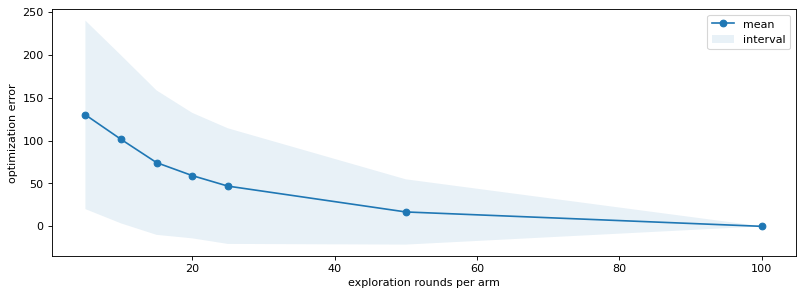

In [125]:
# experiment 2: going greedy (exploitation) after some exploration
ROUNDS = 1000
EXP_ROUNDS_LIST = np.array([5, 10, 15, 20, 25, 50, 100])
# when you are done check what happens when you run 1000 instead of 100 experiments
REPEAT_EXPERIMENTS = 1000

opt_list = []
for repreat in range(REPEAT_EXPERIMENTS):
    opt_list.append([optimization_error(exp_r, EXP_ROUNDS, ROUNDS - EXP_ROUNDS * ARMS, HALF_SIZE) for EXP_ROUNDS in EXP_ROUNDS_LIST ])
    
opt_list = np.array(opt_list)
mean_opt_list = np.mean(opt_list, axis=0) # compute the mean wrt to the number of repeats
max_opt_list = np.std(opt_list, axis=0)
min_opt_list = np.std(opt_list, axis=0)


plt.figure(figsize=(12, 4), dpi=80)
plt.plot(EXP_ROUNDS_LIST, mean_opt_list, marker="o", label="mean")
plt.fill_between(EXP_ROUNDS_LIST, mean_opt_list + max_opt_list, mean_opt_list - min_opt_list, label="interval", alpha=0.1)
#plt.plot(EXP_ROUNDS_LIST, (ROUNDS*ARMS)/np.sqrt(EXP_ROUNDS_LIST), color = "red", label="bound")
plt.xlabel("exploration rounds per arm")
plt.ylabel("optimization error")
plt.legend()

The optimalization error converges faster towards 0 when increasing the number of experiments from 100 to 1000. 

# Experiment 3: $\epsilon$-greedy

Initialise the average reward by playing each arm once. Then, proceed by playing the arm with the highest average return with probability $1-\epsilon$ and an arm sampled uniformly at random otherwise. Check what happens for different values of $\epsilon$.

In [109]:

def regret(exp_r, ROUNDS, epsilon, HALF_SIZE):
    '''    
    Parameters.
    exp_r: expected reward
    ROUNDS: rounds to play
    HALF_SIZE: max reward variation
    '''
    
    ARMS = exp_r.size # number of arms
    
    avg_r = np.random.uniform(exp_r - HALF_SIZE, exp_r + HALF_SIZE)
    arm = np.argmax(avg_r)
    times_played = np.ones(ARMS)
    times_played[arm] += 1
    cumul_r = avg_r[arm]
    
    for r in range (1, ROUNDS):
        
        # going random with probability epsilon 
        p = np.random.random()
        
        if p < epsilon:
            arm = np.random.randint(0, ARMS); # select random arm 
    
        tmp = np.random.uniform(exp_r[arm] - HALF_SIZE, exp_r[arm] + HALF_SIZE)
        cumul_r += tmp
        avg_r[arm] += (tmp - avg_r[arm]) / times_played[arm] 
        
        # update the best arm empirically found
        arm = np.argmax(avg_r)
        times_played[arm] += 1
    
    # compute optimization error
    best_arm = np.argmax(exp_r) # arm of the optimal policy
    regret = exp_r[best_arm] * ROUNDS - cumul_r
    
    return regret

Text(0, 0.5, 'regret')

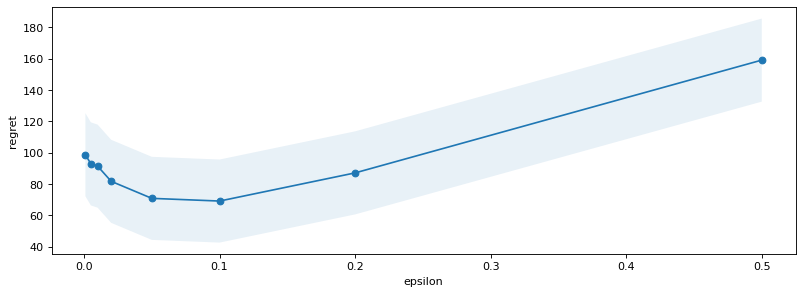

In [110]:
# experiment 3: going epsilon-greedy 
ROUNDS = 1000
EPSILON_LIST = np.array([.001, .005, .01, .02, 0.05, 0.1, 0.2, 0.5]) # probability of choosing a policy at random
# when you are done check what happens when you repeat the experiments 1000 times
REPEAT_EXPERIMENTS = 1000

regret_list = []
for repreat in range(REPEAT_EXPERIMENTS):
    regret_list.append([regret(exp_r, ROUNDS, epsilon, HALF_SIZE) for epsilon in EPSILON_LIST ])

# compute the mean wrt to the number of repeats
regret_list = np.array(regret_list)
regret_list = np.mean(regret_list, axis=0) 
std_regret_list = np.std(regret_list, axis=0)

plt.figure(figsize=(12, 4), dpi=80)
plt.plot(EPSILON_LIST, regret_list, marker="o", label="regret")
plt.fill_between(EPSILON_LIST, regret_list + std_regret_list, regret_list - std_regret_list, label="interval", alpha=0.1)
plt.xlabel("epsilon")
plt.ylabel("regret")

As we can see, the regret goes down while increasing epsilon in the beginning. This means that some exploration is good to maximize the reward and minimize the regret. However too much exploration results in too little exploitation, and results in a larger regret for larger epsilon. 